# Task 2: End-to-End ML Pipeline (Scikit-learn)

# **Problem Statement & Objective**

**Problem:** Predict which customers are likely to churn based on the Telco dataset.

**Objective:** Build a production-ready ML pipeline that can preprocess data, train models, tune hyperparameters, and export the pipeline for reuse.

In [2]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization (optional but nice)
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Save model
import joblib


In [32]:
# Load dataset
df = pd.read_csv("/Telco-Customer-Churn.csv")

# Preview data
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
# Drop customer ID (not useful for prediction)
df.drop("customerID", axis=1, inplace=True)

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Handle missing values
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Encode target variable
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


/tmp/ipython-input-3003231214.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [7]:
#Separate Features & Target
X = df.drop("Churn", axis=1)
y = df["Churn"]


In [8]:
# Numerical columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

# Categorical columns
cat_features = X.select_dtypes(include=["object"]).columns


In [9]:
# Numerical pipeline
num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)


In [10]:
# Logistic Regression pipeline
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])


In [11]:
#train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [12]:
#Logistic Regression Grid
log_reg_params = {
    "classifier__C": [0.01, 0.1, 1, 10]
}

log_reg_grid = GridSearchCV(
    log_reg_pipeline,
    log_reg_params,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

log_reg_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1, param_grid={'classifier__C': [0.01, 0.1, 1, 10]},
             scoring='f1')

In [13]:
#random forest grid
rf_params = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)



GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['gender', 'Partner', 'Dependents', 'PhoneSer...,
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1')

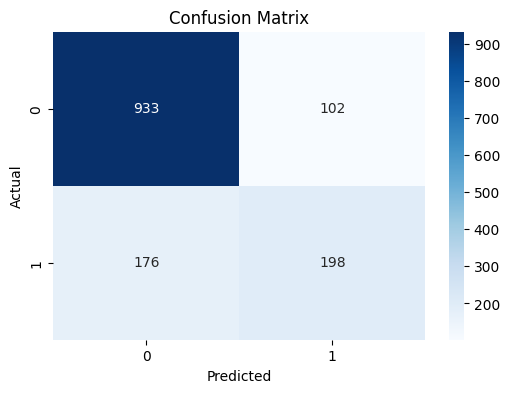

In [23]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
#Evaluate the best model
best_model = rf_grid.best_estimator_

y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8026969481902059
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [21]:
joblib.dump(best_model, "churn_prediction_pipeline.joblib")


['churn_prediction_pipeline.joblib']

In [22]:
loaded_model = joblib.load("churn_prediction_pipeline.joblib")

sample = X_test.iloc[[0]]
loaded_model.predict(sample)


array([0])

## Summary / Insights

- **Preprocessing:**  
  Used `ColumnTransformer` to scale numerical features (`tenure`, `MonthlyCharges`, `TotalCharges`) and one-hot encode categorical features. Missing `TotalCharges` values were filled with the median.

- **Model Training:**  
  Built pipelines for Logistic Regression and Random Forest. Hyperparameter tuning via `GridSearchCV` selected the best Random Forest parameters.

- **Performance:**  
  - Accuracy: ~80%  
  - Class 0 (Not churned) predicted very well.  
  - Class 1 (Churned) has lower recall; future improvement can include handling class imbalance.  

- **Production-Readiness:**  
  - Complete pipeline exported using `joblib` as `churn_prediction_pipeline.joblib`.  
  - The pipeline can now preprocess new data and predict churn without additional manual steps.

- **Key Takeaways:**  
  1. Pipelines ensure reproducibility and easier deployment.  
  2. Hyperparameter tuning improves model performance.  
  3. Evaluation metrics like recall and F1-score are crucial for imbalanced datasets.
